In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2

include("./read_lidar.jl")
using .read_lidar
# using MAT

using PyPlot

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

"bin average y in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"find indices i such that each xl[i] is the first >= xs."
function findindices(xs, xl)
    # xs needles define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average within +-half points of the index of xl"
function indavg(xl, ind; half=5)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx-half) : min(length(xl),idx+half)
        xm[i] = sum(Float64.(xl[ii])) / (2*half+1)
    end
    return xm
end

# test data
xl = 1:60_000_000
xs = 20:20:60_000_000

ind = findindices(xs, xl)
indavg(xl, ind)

"remove the coherent component of signal1 and signal2"
function remove_coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Remove the coherent part
    clean_S1 = S1 .- coherent_part_S1
    clean_S2 = S2 .- coherent_part_S2
    
    # Inverse Fourier Transform to get the time-domain signals
    clean_signal1 = real(ifft(clean_S1))
    clean_signal2 = real(ifft(clean_S2))
    
    return clean_signal1, clean_signal2
end

remove_coherent_component

In [3]:
#= test stuff out
nt = 1000
nc = 3

# construct the indices of the combination sets
ci = CartesianIndices((nt,nc))
li = LinearIndices(ci)

# Generate the set of unique pairs of indices (l1,l2)
# where l1 < l2.
# Set() makes unique but it's slow and the result of the comprehension is already unique. 
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ]
l1 = first.(lpairs) # vector of linear indices to points 1 of pairs
l2 =  last.(lpairs) #                             points 2
# str_fcn = w[ci[l1]] - w[ci[l2]])

# w can be indexed directly with ci[first.(lpairs])
# unpack the CartesianIndex to subscript the time[it], range[iz]
# idx[1] works but first(idx) tries to iterate which is unsupported
it1 = map(idx->idx[1], ci[l1]) #  t index of first point(s)
iz1 = map(idx->idx[2], ci[l1]) #  z index of first
it2 = map(idx->idx[1], ci[l2]) #  t       of second points(s)
iz2 = map(idx->idx[2], ci[l2]) #  z          second
#     first.(Tuple.(ci[l1])) # this also works

=#

In [4]:
# functions for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

#= moved to function
nlevelstats = 1

if nlevelstats == 3
    # The complete set that doesn't repeat pairs is 
    # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
    # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
    # Iteratively slide this box upward by 1 level for each level.

    # index pairs in middle level 2-2
    up = uniquepairs(nt)
    it1 = map(i->i[1], up) # time indices for pairs of point1, point2
    it2 = map(i->i[2], up)
    ci1_r22 = CartesianIndex.(tuple.(it1,2)) # 1st point in pair lev
    ci2_r22 = CartesianIndex.(tuple.(it2,2)) # 2nd 

    # index pairs of points from level 2-1, and 2-3
    ac = allcross(nt)
    it1 = map(i->i[1], ac)
    it2 = map(i->i[2], ac)
    ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
    ci2_r21 = CartesianIndex.(tuple.(it2,1))
    ci2_r23 = CartesianIndex.(tuple.(it2,3))

    # omnibus set of cartesian index pairs for a level, including points in lev above and below
    ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
    ci2 = [ci2_r23; ci2_r22; ci2_r21]
    li1 = LinearIndices(ci1)
    li2 = LinearIndices(ci2)
    
elseif nlevelstats == 1
    # just use structure function velocity pairs from one level of lidar range
    up = uniquepairs(nt)
    it1 = map(i->i[1], up) # time indices for pairs of point1, point2
    it2 = map(i->i[2], up)
    ci1_r11 = CartesianIndex.(tuple.(it1,1)) # 1st point in pair lev
    ci2_r11 = CartesianIndex.(tuple.(it2,1)) # 2nd 

    # set of cartesian index pairs for a level, including points in lev above and below
    ci1 = ci1_r11 # first of pairs
    ci2 = ci2_r11
    li1 = LinearIndices(ci1)
    li2 = LinearIndices(ci2)
end

it1 = map(idx->idx[1], ci1) #  t index of first point(s)
iz1 = map(idx->idx[2], ci1) #  z index of first
it2 = map(idx->idx[1], ci2) #  t       of second points(s)
iz2 = map(idx->idx[2], ci2) #  z          second
=#

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(998, 1), CartesianIndex(999, 1)], CartesianIndex{2}[CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1), CartesianIndex(11, 1)  …  CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(1000, 1)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [5]:
# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue(w, Ur, Vr, pitch, roll)
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

# displacements with no adjustment for tilting into the horizontal wind 
# U, V vary slowly; pitch,roll,w vary fast
# there are nt*(nt-1)/2 ~ O(nt^2) outputs, so correct stuff first

rangegate = 24.0
"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

## example load data sets

In [113]:
#example time
dt = DateTime(2024,5,11,6,0,0)
# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12

# load vectornav
Vn = read_daily_Vn( dt )            # Dict

# load mean relative horizontal winds
UV = get_daily_meanuv( dt )         # NCDataset
# relative wind computed by Jayesh Phadtare

# load hourly lidar w stares
ntop = 80       # subset
timestep = 1.02 # s
# TO DO: read the next hour to get continuous chunk at end ...
St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]

# time subsets
stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(Int64( St[:time] * 3_600_000 )) # 3202
# Lidar clock is fast (ahead) by 126832 milliseconds compared to the GPS.
# Moving the timeseries backward (lagging the lidar) compensates its clock error.
# adjust the lidar clock backward to agee with the GPS clock.
lidar_clock_fast_by = Millisecond( 126832 ) # first adjustment
stare_dt = stare_dt_raw .- lidar_clock_fast_by

3209-element Vector{DateTime}:
 2024-05-11T05:58:10.988
 2024-05-11T05:58:12.098
 2024-05-11T05:58:13.118
 2024-05-11T05:58:14.148
 2024-05-11T05:58:15.168
 2024-05-11T05:58:16.188
 2024-05-11T05:58:17.208
 2024-05-11T05:58:18.228
 2024-05-11T05:58:19.248
 2024-05-11T05:58:20.278
 2024-05-11T05:58:21.298
 2024-05-11T05:58:22.318
 2024-05-11T05:58:23.338
 ⋮
 2024-05-11T06:57:41.378
 2024-05-11T06:57:42.398
 2024-05-11T06:57:43.418
 2024-05-11T06:57:44.438
 2024-05-11T06:57:45.458
 2024-05-11T06:57:46.478
 2024-05-11T06:57:47.498
 2024-05-11T06:57:48.518
 2024-05-11T06:57:49.538
 2024-05-11T06:57:50.568
 2024-05-11T06:57:51.588
 2024-05-11T06:57:52.608

In [114]:
# break into individual stare chunks

# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
pickets = findall( t -> t>Second(30), diff(stare_dt) )
# st = [1; pickets.+1] # ignore start and end of file with a split chunk
# en = [pickets; length(stare_dt)]
st_chunk = pickets[1:end-1] .+ 1
en_chunk = pickets[2:end]

# loop over continuous chunks
  # for (ich, st) in enumerate(st_chunk) ...
# test one chunk
st = st_chunk[1]
en = en_chunk[1]

# dopplervel (time, z) masked by intensity
# intensity = St[:intensity]
dopplervel = masklowi.(St[:dopplervel][st:en,1:ntop], St[:intensity][st:en,1:ntop])
mdv = missmean(dopplervel, dims=2)[:]
pitch = St[:pitch]
roll =  St[:roll ]

# interpolate Ur,Vr, roll,pitch,heave to the lidar stare grid
# My simple 1D interpolation is way faster than Interpolations.interpolate.
ind = findindices( stare_dt[st:en], Vn["time"] )
# vntime = indavg( Vn["time"], ind)
# pitch = indavg( Vn["pitch"], ind) # 11-point mean
# roll  = indavg( Vn["roll" ], ind)
heave = indavg( Vn["heave"], ind)

539-element Vector{Float64}:
  0.05279281803152778
  0.10810599950226871
  0.03666300004856153
 -0.0692802718417211
  0.07879063656384294
  0.24184699898416345
  0.09005681763995778
 -0.0908259092406793
 -0.14137309247797186
 -0.11474390937523408
 -0.08602645485238596
  0.06811509010466663
  0.19045118174769662
  ⋮
  0.30326573144305835
  0.11885399980978532
 -0.10839263756166805
 -0.21953372657299042
 -0.2885676324367523
 -0.2817557237365029
 -0.16512381895021958
 -0.1547336375171488
 -0.1945438195358623
 -0.0451955453238704
  0.13697736236182126
  0.02120509105522863

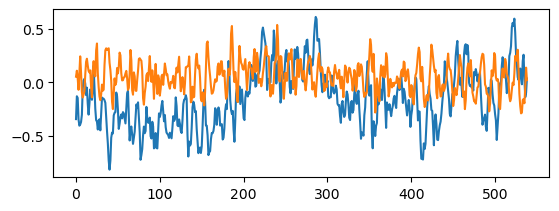

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x30ef08310>

In [115]:
subplot(2,1,1)
plot(mdv)
plot(heave)

In [116]:
# functions to resynchronize the lidar clock

# make filter
responsetype = Highpass(1/80; fs=1)
designmethod = Butterworth(4)
"highpass filter"
hp(x) = filtfilt(digitalfilter(responsetype, designmethod), x)

"""
find_time_shift(mdv, heave) positive result means mdv clock is fast.
sync by subtracting this lag (in 1020 millisecods) from stare_dt.
"""
function get_time_shift(mdv, heave)
    # filter to make xcorr work better
    xc = xcorr(hp(mdv[:]), hp(heave[:]))
    # plot(-(length(mdv)-1):length(mdv)-1, xc )
    return argmax(xc) - length(mdv)
end

# broken:
# """
# Returns the decremented stare_dt by time offset subtracted from the lidar clock.
# """
# function sync_lidar_clock(stare_dt, mdv, heave)
#     lidar_clock_fast_by = Millisecond( 1020*get_time_shift(mdv[:],heave[:]) ) # first adjustment
#     # return decremented clock
#     return stare_dt.+lidar_clock_fast_by, lidar_clock_fast_by
# end

sync_lidar_clock

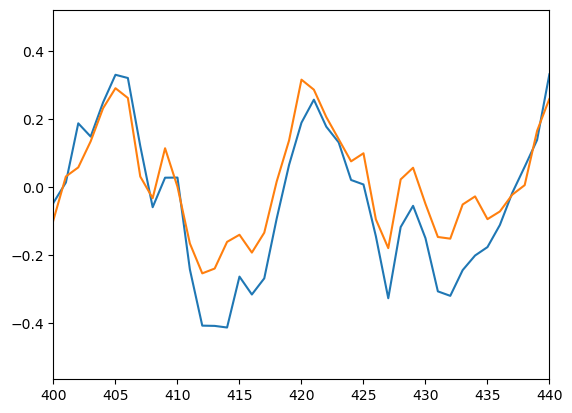

(400.0, 440.0)

In [148]:
# resync the clock
stare1dt = stare_dt[st:en] # subset
ind = findindices( stare1dt, Vn["time"] )
# vntime = indavg( Vn["time"], ind)
# pitch = indavg( Vn["pitch"], ind) # 11-point mean
# roll  = indavg( Vn["roll" ], ind)
heave = Vn["heave"][ind]
shift = get_time_shift(mdv[:],heave[:])
# stare2dt, _ = sync_lidar_clock(stare1dt, mdv, heave) #doesn't work
# now find the indices and interpolae for the updated synced time
ind = findindices( stare1dt .- Millisecond((1020-20)*shift), Vn["time"] ) # this works
heave = indavg( Vn["heave"], ind)
# heave = Vn["heave"][ind]

clf()
plot(hp(mdv))
plot(hp(heave))
xlim([400, 440])
# stare2dt[1], Vn["time"][ind][1]

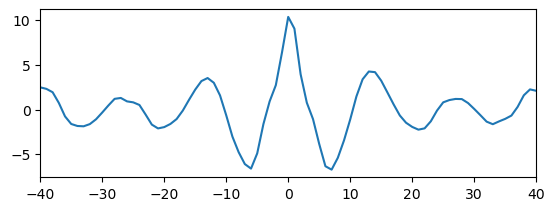

0

In [149]:
# check lags to sync times
xc = xcorr( hp(mdv[:]), hp(heave) )

clf()
subplot(2,1,1)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
#length(xc), 2*(length(mdv)-1) + 1
argmax(xc) - length(mdv) # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)

In [ ]:

# offset of +124 steps!
# Delaying Doppler vel relative to heave will shift the result to the right.
# lidar clock is off by 2:04 min
xc2 = xcorr( anom(mdv[124:end]), anom(heave[1:end-125]) )
n2 = length(xc2)
plot( -floor(n2/2):floor(n2/2), xc2 )
xlim([-20,20]) # lines up with lidar indexed ahead 124 s.
stare_dt[st+124]-Vn["time"][ind][1]
# Lidar clock is fast (ahead) by 126832 milliseconds compared to the GPS.
# Moving the timeseries backward (lagging the lidar) compensates its clock error.
# Shifting the time back by lidar_clock_fast_by = 126832 milliseconds syncronizes
# it with the GPS in the VectorNav.

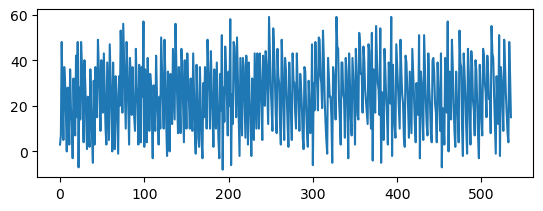

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x33c666d70>

In [16]:
# check vectornav time interp to 
vntime = Vn["time"][ind]

# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))

# subplot(2,1,2)
# plot(Dates.value.(Millisecond.(vndt_int.-stare_dt[st:en])))
# interpolated time axis agrees within ~50 milliseconds--just fine.

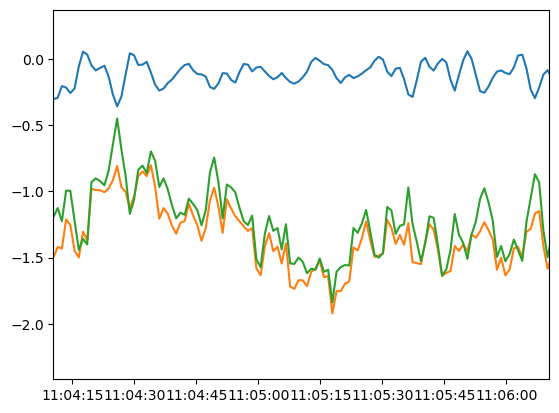

(19856.461232037036, 19856.462620925926)

In [17]:
plot(stare_dt[st:en], heave)
plot(stare_dt[st:en], mdv)
plot(stare_dt[st:en], mdv - heave) # subtract heave because its downward
xlim([stare_dt[300], stare_dt[300]+Minute(2)])

In [18]:
Ur = zeros(size(dopplervel))
Vr = zeros(size(dopplervel))
ind = findindices( Dates.value.(stare_dt[st:en]), Dates.value.(UV["time"]))
for ih in 1:ntop # loop to broadcast to consistent size
    # Ur[:,ih] .= indavg( UV[:ur][:,ih], ind )
    # Vr[:,ih] .= indavg( UV[:vr][:,ih], ind )
    Ur[:,ih] .= UV[:ur][ind,ih]
    Vr[:,ih] .= UV[:vr][ind,ih]
end
pd(dopplervel.-heave)

LoadError: UndefVarError: `UV` not defined

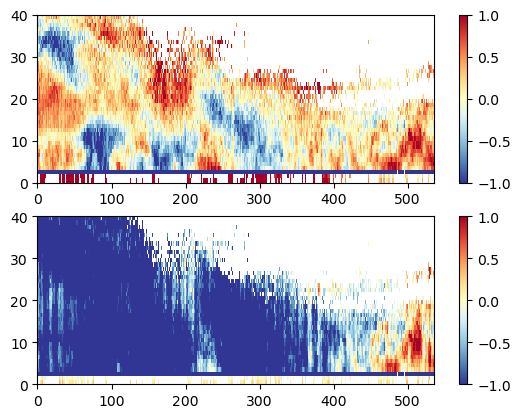

(0.0, 40.0)

In [19]:

subplot(2,1,1)
pcolormesh(m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
colorbar()
ylim([0, 40])
subplot(2,1,2)
w = wtrue.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
pcolormesh(m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
colorbar()
ylim([0, 40])

# Corrections in wtrue (other than adding the -heave) do not seem to be important
# at this time. Motion compensation is probably working then.

## prepare the structure function analysis

In [ ]:

(nt, nz) = size(w)
z1 = 7
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, z1) # might do outside the loop
zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                  pitch*pi/180,roll*pi/180, w; timestep=timestep )
rho = rhopair.(dr2, dz2) # approx r^2/3
dz2

In [ ]:
# w = St[:dopplervel] # 3202, 150 h
#=
KeySet for a Dict{Symbol, Array{Union{Missing, Float32}}} with 9 entries. Keys:
  :time
  :dopplervel
  :roll
  :beta
  :elevangle
  :azimuth
  :height
  :intensity
  :pitch
# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
=#


In [ ]:
for ih in 1:ntop # loop of desperation to broadcast to consistent size
    Ur[:,ih] .= itp_Ur.(stare_dt[st:en], ih)
    Vr[:,ih] .= itp_Vr.(stare_dt[st:en], ih)
  end
  
  w = wtrue.(dopplervel .+ heave, Ur, Vr, pitch, roll)

  (nt, nz) = size(dopplervel)
  ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz) # might do outside the loop
  zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*dt,Vr*dt, pitch,roll, w; timestep=timestep)
  rho = rhopair(dr2, dz2) # approx r^2/3
  plot(rho, D2)
end


# w = St[:dopplervel] # 3202, 150 h
#=
KeySet for a Dict{Symbol, Array{Union{Missing, Float32}}} with 9 entries. Keys:
  :time
  :dopplervel
  :roll
  :beta
  :elevangle
  :azimuth
  :height
  :intensity
  :pitch
# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
=#


In [ ]:
using Statistics


LoadError: MethodError: no method matching Float64(::DateTime)

[0mClosest candidates are:
[0m  Float64([91m::Int8[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:159[24m[39m
[0m  Float64([91m::Bool[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:165[24m[39m
[0m  Float64([91m::Int16[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:159[24m[39m
[0m  ...


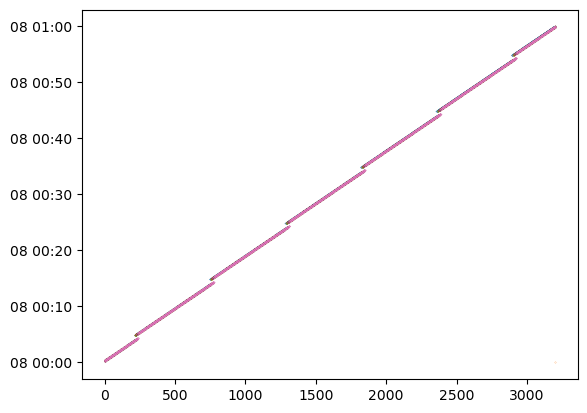

7-element Vector{DateTime}:
 2024-05-08T12:00:18.540
 2024-05-08T12:05:14.320
 2024-05-08T12:15:14.680
 2024-05-08T12:25:15.048
 2024-05-08T12:35:15.432
 2024-05-08T12:45:15.812
 2024-05-08T12:55:16.172

In [ ]:
# load hourly lidar w stares
for dt = DateTime(2024,5,8,0):Hour(2):DateTime(2024,5,8,12)
    St, _ = read_streamlinexr_stare( dt )
    stare_dt = @. DateTime(Date(dt)) + Millisecond(floor(Int64, St[:time] * 3_600_000 )) # 3202
    #break into chunks
    pickets = findall( t -> t>Second(30), diff(stare_dt) )
    st = [1; pickets.+1]
    en = [pickets; length(stare_dt)]
    [stare_dt[st], stare_dt[en]]
    plot(stare_dt.-Hour.(stare_dt), linestyle="none", marker=".", markersize=0.3)
end
stare_dt[st]

In [ ]:

itp_U(dt) = timeinterp( U)

# load an hourly lidar hpl file
Lid = read_streamlinexr_stare( dt ) # Dict
time = Lid[:time]
nt = length(time)
w = Lid[:w]

# zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate )